In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import pandas as pd
import copy

In [2]:
in_fig_lth = 3
in_pxl = 0.04
in_fig_dim = (int(in_fig_lth/in_pxl),int(in_fig_lth/in_pxl))

In [3]:
img0 = Image.open('KIR2DL1_WT_article.png').convert('L')
img = img0.resize(in_fig_dim)

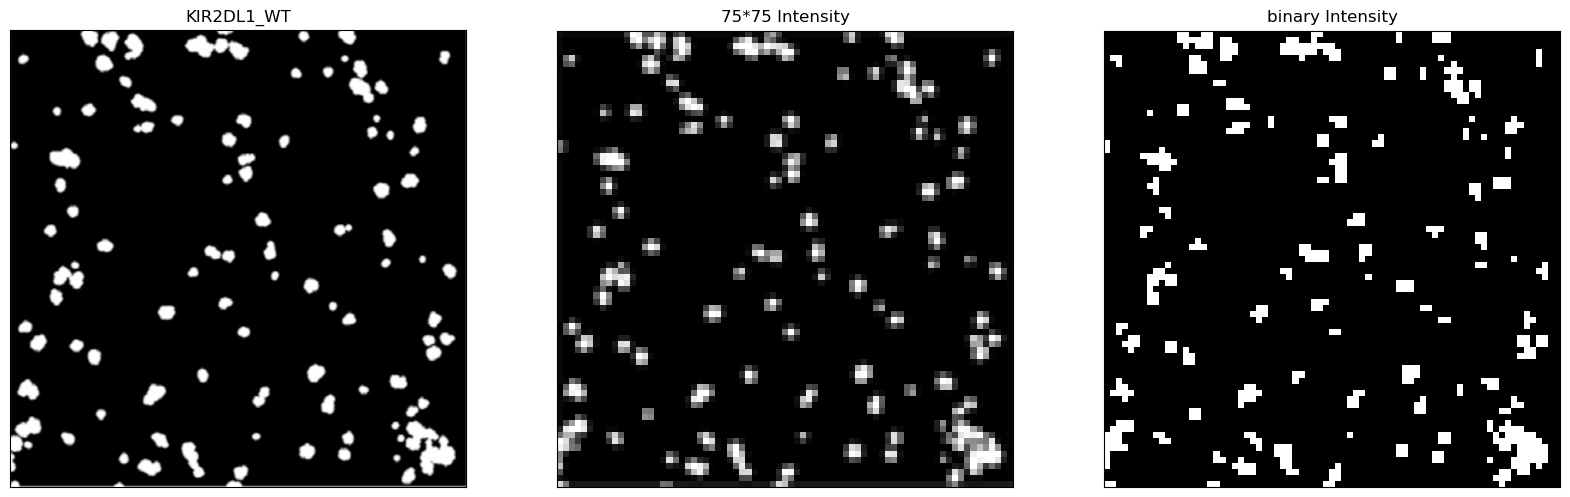

Number of zeros in Original: 5126
Number of ones in Original: 499
total size: 5625 
total sum: 5625


In [4]:
intensity = np.array(img)
threshold = 100
init_bi_inty = (intensity > threshold).astype(int)
fig,ax = plt.subplots(1,3,figsize=(20,18))
ax[0].imshow(img0, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('KIR2DL1_WT')
ax[1].imshow(intensity, cmap='gray', vmin=0, vmax=255)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('75*75 Intensity')
ax[2].imshow(init_bi_inty, cmap='gray', vmin=0, vmax=1)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('binary Intensity')
plt.show()
print(f"Number of zeros in Original: {np.sum(init_bi_inty == 0)}")
print(f"Number of ones in Original: {np.sum(init_bi_inty == 1)}")
print(f'total size: {75*75} \ntotal sum: {np.sum(init_bi_inty == 0)+np.sum(init_bi_inty == 1)}')

In [5]:
def get_clusters(binary_matrix):
    clusters = []
    visited = np.zeros_like(binary_matrix, dtype=bool)
    for y in range(binary_matrix.shape[0]):
        for x in range(binary_matrix.shape[1]):
            if binary_matrix[y, x] == 1 and not visited[y, x]:
                # Found a new cluster
                cluster = []
                # Use BFS or DFS to find the entire cluster
                stack = [(y, x)]
                while stack:
                    cy, cx = stack.pop()
                    if visited[cy, cx]:
                        continue
                    visited[cy, cx] = True
                    cluster.append((cy, cx))
                    # Check neighbors
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < binary_matrix.shape[0] and 0 <= nx < binary_matrix.shape[1]:
                            if binary_matrix[ny, nx] == 1 and not visited[ny, nx]:
                                stack.append((ny, nx))
                clusters.append(cluster)
    return clusters

In [6]:
init_clustors = get_clusters(init_bi_inty)
len(init_clustors)

90

In [7]:
init_clustor_s = np.array([len(cluster) for cluster in init_clustors])
area_lattice = 0.04*0.04
init_clustor_area = init_clustor_s*area_lattice
mean_clustor_lth = np.sqrt(np.mean(init_clustor_area))
mean_clustor_lth

0.09418657606639659

In [9]:
clustor_density = len(init_clustors)/(init_bi_inty.shape[0]*init_bi_inty.shape[1])
new_size = (91,91)
num_new_clustor = int(clustor_density*(new_size[0]*new_size[1]))
num_new_clustor

132

In [10]:
# Rotate a cluster using your method
def rotate_cluster(cluster, angle):
    min_y, min_x = min(y for y, x in cluster), min(x for y, x in cluster)
    cluster_shifted = [(y - min_y, x - min_x) for y, x in cluster]
    max_dim = max(max(y for y, x in cluster_shifted), max(x for y, x in cluster_shifted))
    if angle == 0:
        return cluster
    elif angle == 90:
        return [(x, max_dim - y) for y, x in cluster_shifted]
    elif angle == 180:
        return [(max_dim-y, max_dim-x) for y, x in cluster_shifted]
    elif angle == 270:
        return [(max_dim-x, y) for y, x in cluster_shifted]
# Calculate center of mass for a cluster
def calculate_com(cluster):
    ys, xs = zip(*cluster)
    return round(np.mean(ys)), round(np.mean(xs))
# Translate a cluster based on CoM
def translate_cluster(cluster, target_com):
    current_com = calculate_com(cluster)
    dy, dx = target_com[0] - current_com[0], target_com[1] - current_com[1]
    return [(y + dy, x + dx) for y, x in cluster]
# Check placement validity (side-wise non-touching)
def can_place_cluster(new_matrix, cluster):
    rows, cols = new_matrix.shape
    for y, x in cluster:
        if not (0 <= y < rows and 0 <= x < cols):
            return False
        if new_matrix[y, x] != 0:
            return False
        # Check neighbors (side-wise only)
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < rows and 0 <= nx < cols and new_matrix[ny, nx] != 0:
                return False
    return True

In [11]:
def random_relocation(clusters, init=False):
    new_matrix = np.zeros(new_size)
    rows, cols = new_matrix.shape
    cluster_id = 1
    max_iter = 1000
    iter = 0
    while  cluster_id < num_new_clustor+1 and iter < max_iter:
        i = random.randint(0, len(clusters)-1) if not init else iter%len(clusters)
        cluster = clusters[i]
        placed = False
        attempts = 0
        max_attempts = 100
        while not placed and attempts < max_attempts:
            attempts += 1
            angle = random.choice([0, 90, 180, 270])
            rotated_cluster = rotate_cluster(cluster, angle)
            target_com = (random.randint(0, rows - 1), random.randint(0, cols - 1))
            translated_cluster = translate_cluster(rotated_cluster, target_com)
            if can_place_cluster(new_matrix, translated_cluster):
                for y, x in translated_cluster:
                    new_matrix[y, x] = 1
                placed = True
        iter +=1
        #bi_n_matrix = copy.deepcopy(np.array(new_matrix))
        #bi_n_matrix[bi_n_matrix>=1]=1
        cluster_id = 1+len(get_clusters(new_matrix))
    return new_matrix

In [11]:
relocated_clustor = random_relocation(init_clustors)
rand_clustors = get_clusters(relocated_clustor)
init_clustor_s = np.array([len(cluster) for cluster in rand_clustors])
area_lattice = 0.04*0.04
init_clustor_area = init_clustor_s*area_lattice
mean_clustor_lth = np.sqrt(np.mean(init_clustor_area))
mean_clustor_lth

0.0956001775071257

In [12]:
def Corr_mtrx(matrix, r):
    rows, cols = matrix.shape
    N_chamber = rows * cols
    correlation_sum = []
    for i in range(rows):
        for j in range(cols):
            s_ij = matrix[i, j]
            #print(f'i,j: {i,j} and s_ij: {s_ij}')
            ele = 0
            count = 0
            for rx in range(-r, r+1):
                for ry in range(-r, r+1):
                    ni, nj = (i + rx), (j + ry)
                    if 0 <= ni < rows and 0 <= nj < cols:
                        if rx**2 + ry**2 == r**2:  # Ensuring distance exactly
                            # Get the value at the neighbor location
                            s_neighbor = matrix[ni, nj]
                            #print(f'rx,ry: {rx,ry} and s_neighbor: {s_neighbor}')
                            ele +=(s_ij - matrix.mean()) * (s_neighbor - matrix.mean())
                            count +=1
            # Compute the correlation
            ele = ele/count if count != 0 else 0
            correlation_sum.append(ele)
    C_r = sum(correlation_sum) / (N_chamber)
    return C_r

In [13]:
len(init_clustors)

90

In [13]:
max_distance = int((init_bi_inty.shape[0])/2)
distances = np.arange(0, max_distance + 1)
correlations_init = np.array([Corr_mtrx(init_bi_inty, r) for r in distances])
r_vs_Cr = np.column_stack((distances, correlations_init))
columns = ['r', 'init_binary']
n_iter = 10
np.random.seed(42)
for i in range(n_iter):
    print(f'Iteration:  {i}')
    relocated_clustor = random_relocation(init_clustors)
    correlations_random = np.array([Corr_mtrx(relocated_clustor, r) for r in distances])
    r_vs_Cr = np.column_stack((r_vs_Cr,correlations_random))
    columns.append(f'iter{i}')
df = pd.DataFrame(r_vs_Cr,columns=columns)
df.to_csv('fig_KIR_random_all.csv')

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
